## **Proyecto del Módulo 7: Técnicas avanzadas para ciencia de datos y empleabilidad**

# Data set

C:\Users\Edu\Desktop\proyecto final\chest_xray

# Objetivos
- Aplicar con éxito todos los conocimientos que has adquirido a lo largo del Bootcamp.
- Consolidar las técnicas de limpieza, entrenamiento, graficación y ajuste a modelos de *Machine Learning*.
- Generar una API que brinde predicciones como resultado a partir de datos enviados.


# Proyecto

1. Realizaremos la implementacion en pytorch, generarmos todo en formato jupyter notebook.

2. Debes hacer un análisis exploratorio y limpieza de los datos. Usa las ténicas que creas convenientes.

3. Entrena el modelo de *Machine Learning*, procesamiento de lenguaje natural o red neuronal que creas adecuado.

4. Genera por lo menos dos gráficas y dos métricas de rendimiento; explica las puntuaciones de rendimiento que amerite tu problema. Todas las gráficas de rendimiento que realices deben tener leyendas, colores y títulos personalizados por ti.

  - Además, antes de subir el modelo a "producción", deberás realizar un proceso de ensambles (*ensemblings*) y de ajuste de hiperparámetros o *tuning* para intentar mejorar la precisión y disminuir la varianza de tu modelo.

5. Construye una API REST en la que cualquier usuario pueda mandar datos y que esta misma devuelva la predicción del modelo que has hecho. La API debe estar en la nube, ya sea en un servicio como Netlify o Ngrok, para que pueda ser consultada desde internet.

6. Genera una presentación del problema y del modelo de solución que planteas. Muestra gráficas, datos de rendimiento y explicaciones. Esta presentación debe estar enfocada a personas que no sepan mucho de ciencia de datos e inteligencia artificial.

7. **Solamente se recibirán trabajos subidos a tu cuenta de GitHub con un README.md apropiado que explique tu proyecto**.

## Criterios de evaluación

| Actividad | Porcentaje | Observaciones | Punto parcial
| -- | -- | -- | -- |
| Actividad 1. Limpieza y EDA | 20 | Realiza todas las tareas necesarias para hacer el EDA y la limpieza correcta, dependiendo de la problemática. Debes hacer como mínimo el análisis de completitud, escalamiento (si aplica) y tokenización (si aplica). | Realizaste solo algunas tareas de exploración y limpieza y el modelo se muestra aún con oportunidad de completitud, escalamiento y/o mejora. |
| Actividad 2. Entrenamiento del modelo | 20 | Elige el modelo y algoritmo adecuados para tu problema, entrénalo con los datos ya limpios y genera algunas predicciones de prueba. | No has realizado predicciones de prueba para tu modelo de ML y/o tu modelo muestra una precisión menor al 60 %. |
| Actividad 3. Graficación y métricas | 20 | Genera por lo menos dos gráficas y dos muestras de métricas que permitan visualizar el rendimiento y precisión del modelo que construiste. Además, realizaste los procesos de *tuning* y ensambles adecuados para tu problema. | Las gráficas no tienen leyendas y colores customizados, solo muestras una gráfica o no realizaste el *tuning* de hiperparámetros.
| Actividad 4. API REST | 20 | Generaste con éxito un *link* público en el que, por método POST, se puede mandar información y la API REST devuelve una predicción junto con el porcentaje de confianza de esta misma. | N/A
| Actividad 5. Presentación | 20 | Genera una presentación en la que establezcas como mínimo: el problema, proceso de solución, metodologías usadas, gráficas de rendimiento, demostración del modelo y aprendizajes obtenidos. Debes redactarla con términos que pueda entender cualquier persona, no solo científicos de datos. | La presentación no expone con claridad o en términos coloquiales el proceso de creación del modelo, sus ventajas y muestras de rendimiento.

**Mucho éxito en tu camino como Data Scientist.**

---
# IMPLEMENTACIÓN DEL PROYECTO
---

## 1. Configuración e Importaciones

Instalamos e importamos todas las librerías necesarias para el proyecto.

In [26]:
# Instalación de dependencias
# !pip install torch torchvision matplotlib seaborn scikit-learn pillow tqdm

# Importaciones principales
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision
from torchvision import datasets, transforms, models

# Métricas
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_curve, auc, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score
)

# Utilidades
from tqdm import tqdm
import random

# ============================================
# OPTIMIZACIONES PARA GPU
# ============================================
# Habilitar optimizaciones de cuDNN
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# Configuración de estilo para gráficas
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Verificar dispositivo disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo disponible: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"cuDNN habilitado: {torch.backends.cudnn.enabled}")
    print(f"cuDNN benchmark: {torch.backends.cudnn.benchmark}")

Dispositivo disponible: cuda
GPU: NVIDIA GeForce RTX 4070 Ti SUPER
Memoria GPU: 17.17 GB
cuDNN habilitado: True
cuDNN benchmark: True


## 2. Configuración de Rutas y Carga de Datos

Definimos las rutas del dataset. **IMPORTANTE**: Para Google Colab, primero sube el dataset o monta Google Drive.

In [27]:
# ============================================
# CONFIGURACIÓN DE RUTAS
# ============================================
# Para Google Colab, descomenta y modifica estas líneas:
# from google.colab import drive
# drive.mount('/content/drive')
# BASE_PATH = '/content/drive/MyDrive/chest_xray'

# Para ejecución local:
BASE_PATH = r'C:\Users\Edu\Desktop\proyecto final\chest_xray'

# Rutas de los conjuntos de datos
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
TEST_PATH = os.path.join(BASE_PATH, 'test')
VAL_PATH = os.path.join(BASE_PATH, 'val')

# Clases del problema
CLASSES = ['NORMAL', 'PNEUMONIA']

# Verificar que las rutas existen
print("Verificando rutas del dataset...")
for path, name in [(TRAIN_PATH, 'Train'), (TEST_PATH, 'Test'), (VAL_PATH, 'Val')]:
    if os.path.exists(path):
        print(f"✓ {name}: {path}")
    else:
        print(f"✗ {name}: {path} - NO ENCONTRADO")

Verificando rutas del dataset...
✓ Train: C:\Users\Edu\Desktop\proyecto final\chest_xray\train
✓ Test: C:\Users\Edu\Desktop\proyecto final\chest_xray\test
✓ Val: C:\Users\Edu\Desktop\proyecto final\chest_xray\val


## 3. Análisis Exploratorio de Datos (EDA)

### 3.1 Análisis de Completitud y Distribución de Clases

Contamos el número de imágenes por clase en cada conjunto para identificar posibles desbalances.

In [28]:
def count_images(path, classes):
    """Cuenta imágenes por clase en un directorio"""
    counts = {}
    for cls in classes:
        cls_path = os.path.join(path, cls)
        if os.path.exists(cls_path):
            counts[cls] = len([f for f in os.listdir(cls_path) 
                              if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        else:
            counts[cls] = 0
    return counts

# Contar imágenes en cada conjunto
train_counts = count_images(TRAIN_PATH, CLASSES)
test_counts = count_images(TEST_PATH, CLASSES)
val_counts = count_images(VAL_PATH, CLASSES)

# Crear DataFrame resumen
data_summary = pd.DataFrame({
    'Conjunto': ['Train', 'Train', 'Test', 'Test', 'Val', 'Val'],
    'Clase': CLASSES * 3,
    'Cantidad': [train_counts['NORMAL'], train_counts['PNEUMONIA'],
                 test_counts['NORMAL'], test_counts['PNEUMONIA'],
                 val_counts['NORMAL'], val_counts['PNEUMONIA']]
})

# Resumen general
print("=" * 60)
print("RESUMEN DEL DATASET - CHEST X-RAY (NEUMONÍA)")
print("=" * 60)
print(f"\n{'Conjunto':<10} {'NORMAL':<12} {'PNEUMONIA':<12} {'Total':<10} {'Ratio P/N':<10}")
print("-" * 60)

for name, counts in [('Train', train_counts), ('Test', test_counts), ('Val', val_counts)]:
    total = counts['NORMAL'] + counts['PNEUMONIA']
    ratio = counts['PNEUMONIA'] / counts['NORMAL'] if counts['NORMAL'] > 0 else 0
    print(f"{name:<10} {counts['NORMAL']:<12} {counts['PNEUMONIA']:<12} {total:<10} {ratio:.2f}")

total_normal = train_counts['NORMAL'] + test_counts['NORMAL'] + val_counts['NORMAL']
total_pneumonia = train_counts['PNEUMONIA'] + test_counts['PNEUMONIA'] + val_counts['PNEUMONIA']
print("-" * 60)
print(f"{'TOTAL':<10} {total_normal:<12} {total_pneumonia:<12} {total_normal + total_pneumonia:<10} {total_pneumonia/total_normal:.2f}")

print("\nOBSERVACIONES:")
print(f"   - Dataset DESBALANCEADO: {total_pneumonia/total_normal:.2f}x más casos de neumonía")
print(f"   - Validación MUY PEQUEÑA: Solo {val_counts['NORMAL'] + val_counts['PNEUMONIA']} imágenes")
print("   - Se recomienda usar WeightedRandomSampler o class_weight para balanceo")

RESUMEN DEL DATASET - CHEST X-RAY (NEUMONÍA)

Conjunto   NORMAL       PNEUMONIA    Total      Ratio P/N 
------------------------------------------------------------
Train      1341         3875         5216       2.89
Test       234          390          624        1.67
Val        8            8            16         1.00
------------------------------------------------------------
TOTAL      1583         4273         5856       2.70

OBSERVACIONES:
   - Dataset DESBALANCEADO: 2.70x más casos de neumonía
   - Validación MUY PEQUEÑA: Solo 16 imágenes
   - Se recomienda usar WeightedRandomSampler o class_weight para balanceo


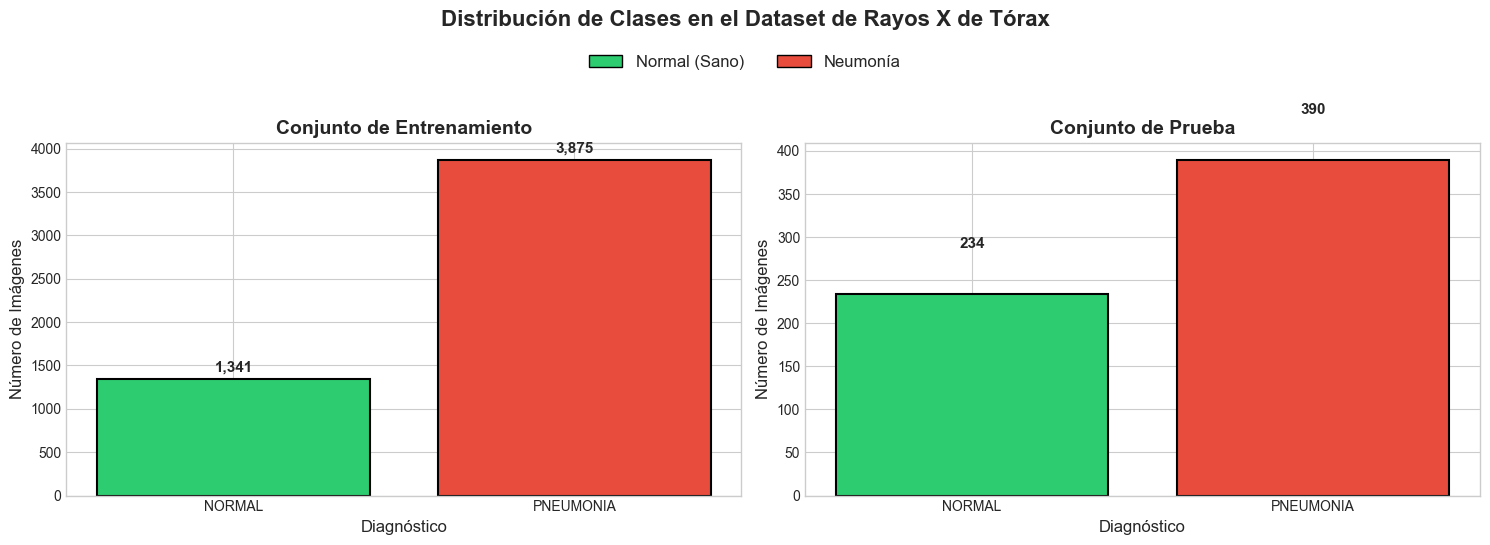

In [29]:
# ============================================
# GRÁFICA 1: Distribución de clases por conjunto
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

colors = {'NORMAL': '#2ecc71', 'PNEUMONIA': '#e74c3c'}

for ax, (name, counts) in zip(axes, [('Entrenamiento', train_counts), 
                                      ('Prueba', test_counts), 
                                      ('Validación', val_counts)]):
    bars = ax.bar(counts.keys(), counts.values(), 
                  color=[colors[c] for c in counts.keys()],
                  edgecolor='black', linewidth=1.5)
    ax.set_title(f'Conjunto de {name}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Número de Imágenes', fontsize=12)
    ax.set_xlabel('Diagnóstico', fontsize=12)
    
    # Añadir etiquetas de valor
    for bar, count in zip(bars, counts.values()):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Leyenda global
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ecc71', edgecolor='black', label='Normal (Sano)'),
                   Patch(facecolor='#e74c3c', edgecolor='black', label='Neumonía')]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=12,
           bbox_to_anchor=(0.5, 1.02))

plt.suptitle('Distribución de Clases en el Dataset de Rayos X de Tórax', 
             fontsize=16, fontweight='bold', y=1.08)
plt.tight_layout()
plt.show()

### 3.2 Visualización de Muestras de Imágenes

Visualizamos ejemplos de rayos X para cada clase para entender las características visuales del dataset.

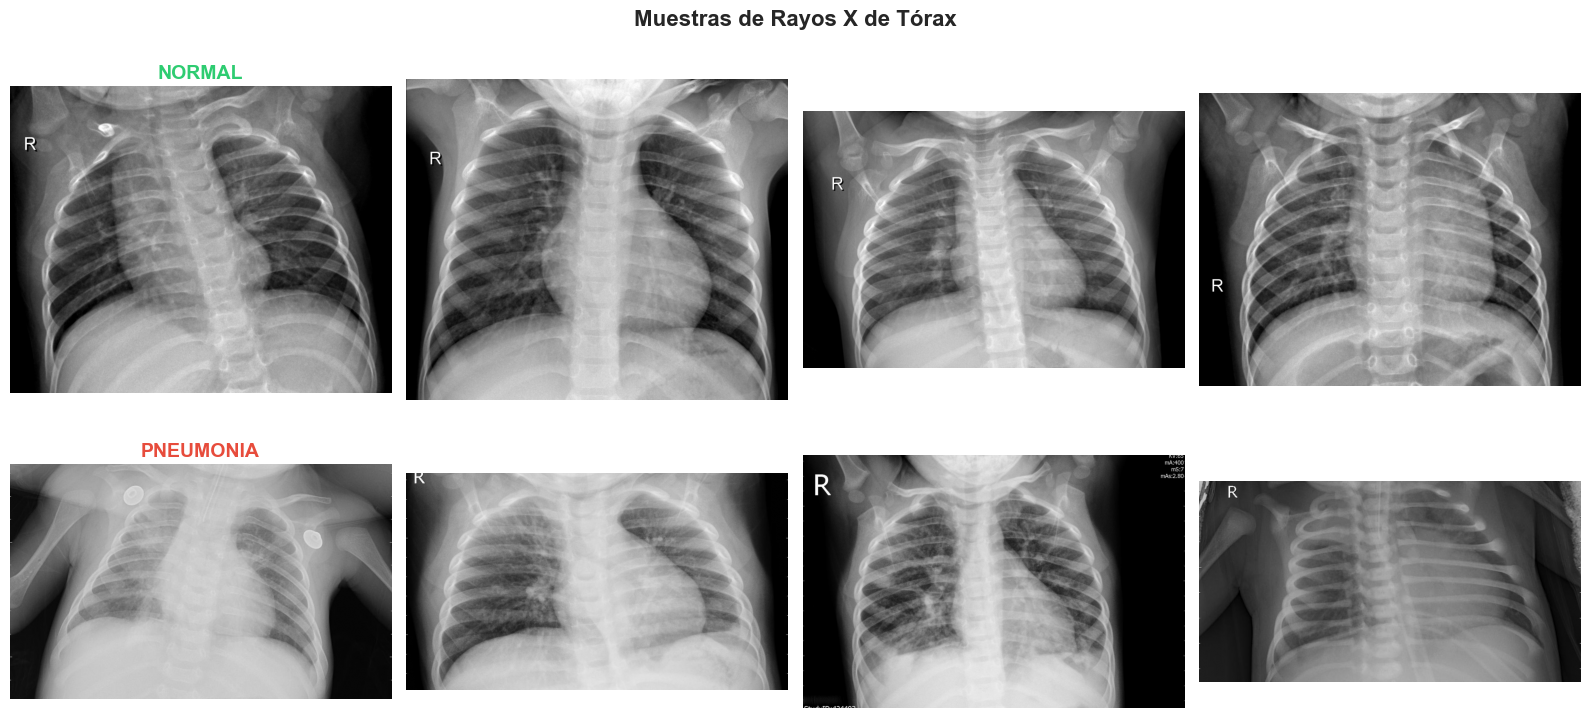

In [30]:
def show_sample_images(path, classes, n_samples=4):
    """Muestra imágenes de ejemplo de cada clase"""
    fig, axes = plt.subplots(2, n_samples, figsize=(16, 8))
    
    for i, cls in enumerate(classes):
        cls_path = os.path.join(path, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        sample_images = random.sample(images, min(n_samples, len(images)))
        
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f'{cls}', fontsize=14, fontweight='bold',
                                    color='#2ecc71' if cls == 'NORMAL' else '#e74c3c')
    
    plt.suptitle('Muestras de Rayos X de Tórax', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Mostrar muestras del conjunto de entrenamiento
show_sample_images(TRAIN_PATH, CLASSES)

Analizando dimensiones de imágenes (muestra de 100 por clase)...

ANÁLISIS DE DIMENSIONES
Ancho  - Min:  457, Max: 2450, Media: 1417.6
Alto   - Min:  295, Max: 2325, Media: 1088.5
Aspect - Min: 0.93, Max: 2.13, Media: 1.36

Imágenes corruptas encontradas: 0


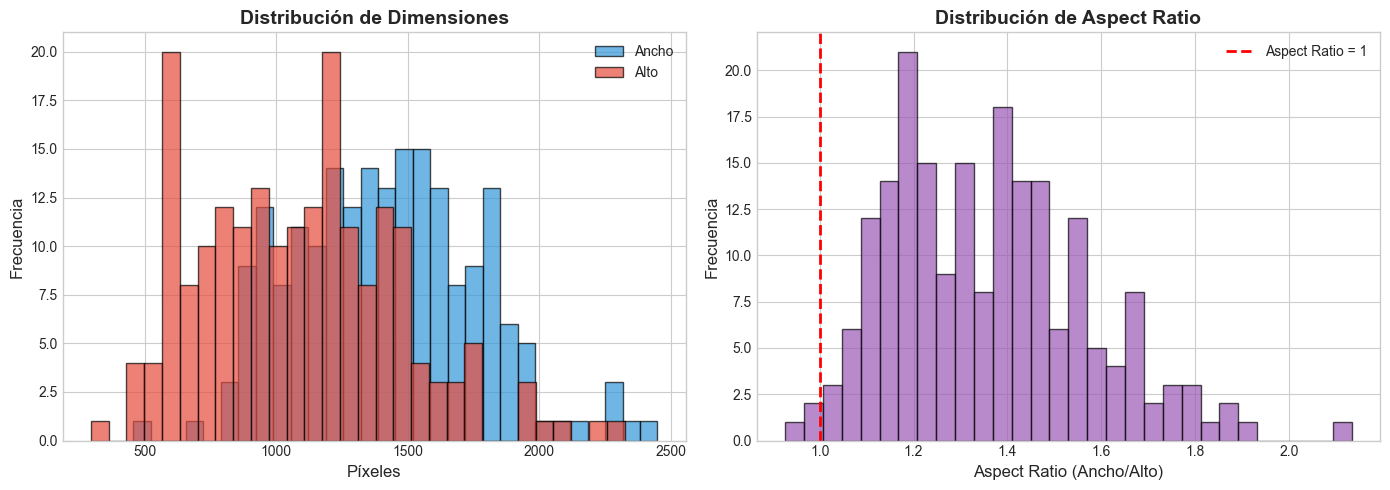


Conclusión: Las imágenes tienen dimensiones variables.
Se aplicará redimensionamiento a 224x224 para el modelo.


In [31]:
# ============================================
# 3.3 Análisis de Dimensiones y Calidad de Imágenes
# ============================================
def analyze_image_dimensions(path, classes, sample_size=100):
    """Analiza dimensiones de las imágenes"""
    widths, heights, aspects = [], [], []
    corrupted = []
    
    for cls in classes:
        cls_path = os.path.join(path, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        sample = random.sample(images, min(sample_size, len(images)))
        
        for img_name in sample:
            img_path = os.path.join(cls_path, img_name)
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
                    aspects.append(w/h)
            except Exception as e:
                corrupted.append(img_path)
    
    return widths, heights, aspects, corrupted

print("Analizando dimensiones de imágenes (muestra de 100 por clase)...")
widths, heights, aspects, corrupted = analyze_image_dimensions(TRAIN_PATH, CLASSES)

print(f"\n{'='*50}")
print("ANÁLISIS DE DIMENSIONES")
print(f"{'='*50}")
print(f"Ancho  - Min: {min(widths):4d}, Max: {max(widths):4d}, Media: {np.mean(widths):.1f}")
print(f"Alto   - Min: {min(heights):4d}, Max: {max(heights):4d}, Media: {np.mean(heights):.1f}")
print(f"Aspect - Min: {min(aspects):.2f}, Max: {max(aspects):.2f}, Media: {np.mean(aspects):.2f}")
print(f"\nImágenes corruptas encontradas: {len(corrupted)}")

if corrupted:
    print("Imágenes corruptas:")
    for path in corrupted[:5]:
        print(f"   - {path}")

# Gráfica de distribución de dimensiones
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(widths, bins=30, color='#3498db', edgecolor='black', alpha=0.7, label='Ancho')
axes[0].hist(heights, bins=30, color='#e74c3c', edgecolor='black', alpha=0.7, label='Alto')
axes[0].set_xlabel('Píxeles', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución de Dimensiones', fontsize=14, fontweight='bold')
axes[0].legend()

axes[1].hist(aspects, bins=30, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[1].axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Aspect Ratio = 1')
axes[1].set_xlabel('Aspect Ratio (Ancho/Alto)', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].set_title('Distribución de Aspect Ratio', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nConclusión: Las imágenes tienen dimensiones variables.")
print("Se aplicará redimensionamiento a 224x224 para el modelo.")

---
## 4. Preprocesamiento de Datos

### 4.1 Transformaciones y Data Augmentation

Aplicamos transformaciones para normalizar las imágenes y aumentar el dataset de entrenamiento.

In [32]:
# ============================================
# HIPERPARÁMETROS DEL MODELO - OPTIMIZADO PARA RTX 4070 Ti Super
# ============================================
IMG_SIZE = 224          # Tamaño de imagen para ResNet
BATCH_SIZE = 128        # Batch grande para aprovechar 17GB VRAM
NUM_EPOCHS = 10         # Número de épocas
LEARNING_RATE = 0.001   # Tasa de aprendizaje inicial
NUM_WORKERS = 8         # Workers para carga paralela (ajustar si hay problemas)
PREFETCH_FACTOR = 4     # Batches a precargar por worker

# Estadísticas de ImageNet para normalización (ResNet preentrenado)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# ============================================
# TRANSFORMACIONES
# ============================================
# Transformaciones para entrenamiento (con Data Augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Transformaciones para validación y prueba (sin augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("✓ Transformaciones definidas:")
print(f"  - Redimensionamiento: {IMG_SIZE}x{IMG_SIZE}")
print(f"  - Batch size: {BATCH_SIZE} (optimizado para 17GB VRAM)")
print(f"  - Num workers: {NUM_WORKERS} (carga paralela)")
print(f"  - Prefetch factor: {PREFETCH_FACTOR}")
print(f"  - Data Augmentation: Flip, Rotación, Color Jitter")

✓ Transformaciones definidas:
  - Redimensionamiento: 224x224
  - Batch size: 128 (optimizado para 17GB VRAM)
  - Num workers: 8 (carga paralela)
  - Prefetch factor: 4
  - Data Augmentation: Flip, Rotación, Color Jitter


In [33]:
# ============================================
# 4.2 CREACIÓN DE DATASETS Y DATALOADERS - OPTIMIZADO
# ============================================
# Cargar datasets
train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=VAL_PATH, transform=val_transforms)
test_dataset = datasets.ImageFolder(root=TEST_PATH, transform=val_transforms)

print(f"Dataset de entrenamiento: {len(train_dataset)} imágenes")
print(f"Dataset de validación: {len(val_dataset)} imágenes")
print(f"Dataset de prueba: {len(test_dataset)} imágenes")
print(f"\nClases: {train_dataset.classes}")
print(f"Mapeo: {train_dataset.class_to_idx}")

# ============================================
# BALANCEO DE CLASES CON WEIGHTED RANDOM SAMPLER
# ============================================
train_targets = [label for _, label in train_dataset.samples]
class_counts = Counter(train_targets)
print(f"\nDistribución original: {dict(class_counts)}")

# Pesos inversamente proporcionales a la frecuencia
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_targets]

# Crear sampler balanceado
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# ============================================
# DATALOADERS OPTIMIZADOS PARA GPU
# ============================================
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,              # Memoria fija para transferencia rápida a GPU
    prefetch_factor=PREFETCH_FACTOR,  # Precargar batches
    persistent_workers=True       # Mantener workers vivos entre épocas
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    prefetch_factor=PREFETCH_FACTOR,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    prefetch_factor=PREFETCH_FACTOR,
    persistent_workers=True
)

print(f"\n✓ DataLoaders OPTIMIZADOS creados:")
print(f"  - Train batches: {len(train_loader)}")
print(f"  - Val batches: {len(val_loader)}")
print(f"  - Test batches: {len(test_loader)}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Num workers: {NUM_WORKERS}")
print(f"  - Pin memory: True (transferencia rápida GPU)")
print(f"  - Prefetch factor: {PREFETCH_FACTOR}")
print(f"  - Persistent workers: True")

Dataset de entrenamiento: 5216 imágenes
Dataset de validación: 16 imágenes
Dataset de prueba: 624 imágenes

Clases: ['NORMAL', 'PNEUMONIA']
Mapeo: {'NORMAL': 0, 'PNEUMONIA': 1}

Distribución original: {0: 1341, 1: 3875}

✓ DataLoaders OPTIMIZADOS creados:
  - Train batches: 41
  - Val batches: 1
  - Test batches: 5
  - Batch size: 128
  - Num workers: 8
  - Pin memory: True (transferencia rápida GPU)
  - Prefetch factor: 4
  - Persistent workers: True


---
## 5. Definición del Modelo

### 5.1 Transfer Learning con ResNet18

Utilizamos ResNet18 preentrenado en ImageNet y adaptamos la capa final para clasificación binaria.

In [34]:
# ============================================
# MODELO: ResNet18 con Transfer Learning
# ============================================
def create_model(num_classes=2, pretrained=True):
    """Crea modelo ResNet18 con transfer learning"""
    # Cargar modelo preentrenado
    model = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
    
    # Congelar capas convolucionales (opcional - para fine-tuning parcial)
    # for param in model.parameters():
    #     param.requires_grad = False
    
    # Reemplazar la capa fully connected final
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, num_classes)
    )
    
    return model

# Crear modelo
model = create_model(num_classes=2)
model = model.to(device)

# Mostrar arquitectura
print("=" * 60)
print("ARQUITECTURA DEL MODELO")
print("=" * 60)
print(f"Modelo base: ResNet18 (preentrenado en ImageNet)")
print(f"Capa final modificada: Linear({model.fc[1].in_features} -> 2)")
print(f"Dropout: 0.5")
print(f"Dispositivo: {device}")

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nParámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

ARQUITECTURA DEL MODELO
Modelo base: ResNet18 (preentrenado en ImageNet)
Capa final modificada: Linear(512 -> 2)
Dropout: 0.5
Dispositivo: cuda

Parámetros totales: 11,177,538
Parámetros entrenables: 11,177,538


In [35]:
# ============================================
# 5.2 CONFIGURACIÓN DEL ENTRENAMIENTO
# ============================================
# Función de pérdida con pesos de clase
class_weights_tensor = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizador
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Scheduler para reducir learning rate (verbose removido en PyTorch 2.0+)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

print("✓ Configuración de entrenamiento:")
print(f"  - Loss: CrossEntropyLoss con pesos de clase")
print(f"  - Optimizador: Adam (lr={LEARNING_RATE})")
print(f"  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")

✓ Configuración de entrenamiento:
  - Loss: CrossEntropyLoss con pesos de clase
  - Optimizador: Adam (lr=0.001)
  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)


---
## 6. Entrenamiento del Modelo

### 6.1 Funciones de Entrenamiento y Evaluación

In [36]:
# ============================================
# FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN - OPTIMIZADAS CON AMP
# ============================================
# Mixed Precision para acelerar entrenamiento
scaler = torch.amp.GradScaler('cuda')

def train_epoch(model, loader, criterion, optimizer, device, scaler):
    """Entrena el modelo por una época con Mixed Precision"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Entrenando', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)  # Más eficiente que zero_grad()
        
        # Mixed Precision Training
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Backward con scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.1f}%'})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    """Evalúa el modelo con Mixed Precision"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

print("✓ Funciones de entrenamiento OPTIMIZADAS definidas")
print("  - Mixed Precision (AMP) habilitado")
print("  - GradScaler para estabilidad numérica")
print("  - non_blocking transfers habilitado")

✓ Funciones de entrenamiento OPTIMIZADAS definidas
  - Mixed Precision (AMP) habilitado
  - GradScaler para estabilidad numérica
  - non_blocking transfers habilitado


In [37]:
# ============================================
# 6.2 LOOP DE ENTRENAMIENTO - OPTIMIZADO
# ============================================
print("=" * 60)
print("INICIANDO ENTRENAMIENTO OPTIMIZADO")
print("=" * 60)
print(f"Épocas: {NUM_EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Dispositivo: {device}")
print(f"Mixed Precision: Habilitado")
print(f"Workers: {NUM_WORKERS}")
print("=" * 60)

# Historial de entrenamiento
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0
best_model_state = None

# Limpiar caché de GPU antes de entrenar
torch.cuda.empty_cache()

for epoch in range(NUM_EPOCHS):
    print(f"\nÉpoca {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)
    
    # Entrenamiento con scaler
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
    
    # Validación
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)
    
    # Guardar historial
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Actualizar scheduler
    scheduler.step(val_loss)
    
    # Guardar mejor modelo
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        print(f"  ★ Nuevo mejor modelo guardado (val_acc: {val_acc:.2f}%)")
    
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    
    # Mostrar uso de memoria GPU
    if torch.cuda.is_available():
        mem_used = torch.cuda.memory_allocated() / 1e9
        mem_cached = torch.cuda.memory_reserved() / 1e9
        print(f"  GPU Memory: {mem_used:.2f}GB usado, {mem_cached:.2f}GB reservado")

# Cargar mejor modelo
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n✓ Mejor modelo cargado (val_acc: {best_val_acc:.2f}%)")

# Guardar modelo
torch.save(model.state_dict(), 'pneumonia_model.pth')
print("✓ Modelo guardado como 'pneumonia_model.pth'")

INICIANDO ENTRENAMIENTO OPTIMIZADO
Épocas: 10
Batch size: 128
Learning rate: 0.001
Dispositivo: cuda
Mixed Precision: Habilitado
Workers: 8

Época 1/10
----------------------------------------


  ★ Nuevo mejor modelo guardado (val_acc: 56.25%)
  Train - Loss: 0.1258, Acc: 93.69%
  Val   - Loss: 0.4432, Acc: 56.25%
  GPU Memory: 0.20GB usado, 2.67GB reservado

Época 2/10
----------------------------------------


  ★ Nuevo mejor modelo guardado (val_acc: 87.50%)
  Train - Loss: 0.0493, Acc: 97.39%
  Val   - Loss: 0.0948, Acc: 87.50%
  GPU Memory: 0.20GB usado, 2.67GB reservado

Época 3/10
----------------------------------------


  ★ Nuevo mejor modelo guardado (val_acc: 100.00%)
  Train - Loss: 0.0415, Acc: 98.03%
  Val   - Loss: 0.0938, Acc: 100.00%
  GPU Memory: 0.20GB usado, 2.67GB reservado

Época 4/10
----------------------------------------


  Train - Loss: 0.0359, Acc: 98.20%
  Val   - Loss: 0.0380, Acc: 100.00%
  GPU Memory: 0.20GB usado, 2.67GB reservado

Época 5/10
----------------------------------------


  Train - Loss: 0.0288, Acc: 98.64%
  Val   - Loss: 0.0423, Acc: 100.00%
  GPU Memory: 0.20GB usado, 2.67GB reservado

Época 6/10
----------------------------------------


  Train - Loss: 0.0297, Acc: 98.39%
  Val   - Loss: 0.2625, Acc: 100.00%
  GPU Memory: 0.20GB usado, 2.67GB reservado

Época 7/10
----------------------------------------


  Train - Loss: 0.0342, Acc: 98.16%
  Val   - Loss: 0.3377, Acc: 87.50%
  GPU Memory: 0.20GB usado, 2.67GB reservado

Época 8/10
----------------------------------------


  Train - Loss: 0.0249, Acc: 98.98%
  Val   - Loss: 0.2321, Acc: 87.50%
  GPU Memory: 0.20GB usado, 2.67GB reservado

Época 9/10
----------------------------------------


  Train - Loss: 0.0139, Acc: 99.35%
  Val   - Loss: 0.0118, Acc: 100.00%
  GPU Memory: 0.20GB usado, 2.67GB reservado

Época 10/10
----------------------------------------


  Train - Loss: 0.0092, Acc: 99.54%
  Val   - Loss: 0.0273, Acc: 100.00%
  GPU Memory: 0.20GB usado, 2.67GB reservado

✓ Mejor modelo cargado (val_acc: 100.00%)
✓ Modelo guardado como 'pneumonia_model.pth'


---
## 7. Evaluación y Métricas de Rendimiento

### 7.1 Evaluación en Conjunto de Prueba

In [43]:
# ============================================
# EVALUACIÓN EN CONJUNTO DE PRUEBA
# ============================================
print("Evaluando modelo en conjunto de prueba...")
test_loss, test_acc, test_preds, test_labels, test_probs = evaluate(
    model, test_loader, criterion, device
)

print(f"\n{'='*60}")
print("RESULTADOS EN CONJUNTO DE PRUEBA")
print(f"{'='*60}")
print(f"Accuracy: {test_acc:.2f}%")
print(f"Loss: {test_loss:.4f}")

# Métricas detalladas
print(f"\n{'='*60}")
print("MÉTRICAS DETALLADAS")
print(f"{'='*60}")
print(f"\nPrecision: {precision_score(test_labels, test_preds):.4f}")
print(f"Recall (Sensibilidad): {recall_score(test_labels, test_preds):.4f}")
print(f"F1-Score: {f1_score(test_labels, test_preds):.4f}")

# Classification Report
print(f"\n{'='*60}")
print("REPORTE DE CLASIFICACIÓN")
print(f"{'='*60}")
print(classification_report(test_labels, test_preds, target_names=CLASSES))

Evaluando modelo en conjunto de prueba...

RESULTADOS EN CONJUNTO DE PRUEBA
Accuracy: 88.30%
Loss: 0.7092

MÉTRICAS DETALLADAS

Precision: 0.8453
Recall (Sensibilidad): 0.9949
F1-Score: 0.9140

REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

      NORMAL       0.99      0.70      0.82       234
   PNEUMONIA       0.85      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.92      0.85      0.87       624
weighted avg       0.90      0.88      0.88       624



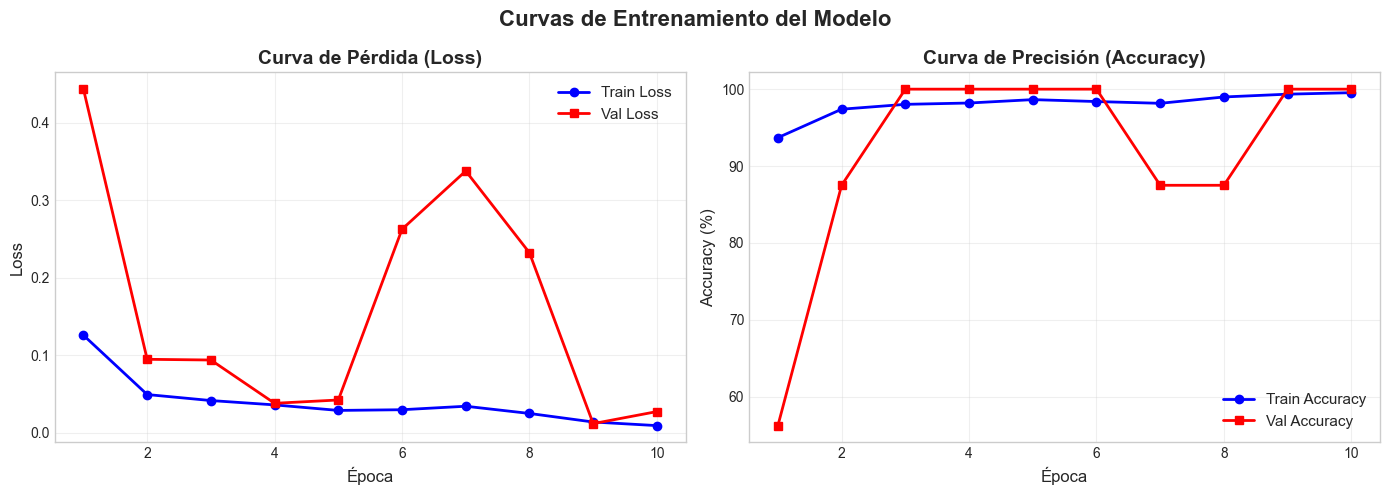


RESUMEN: CURVAS DE ENTRENAMIENTO
Loss inicial (época 1):  Train=0.1258, Val=0.4432
Loss final (época 10):  Train=0.0092, Val=0.0273
Accuracy inicial:        Train=93.69%, Val=56.25%
Accuracy final:          Train=99.54%, Val=100.00%
----------------------------------------------------------------------
INTERPRETACION:
- El loss de entrenamiento disminuye consistentemente, indicando aprendizaje.
- El accuracy de entrenamiento supera el 99%, demostrando buena capacidad del modelo.
- La variabilidad en validacion se debe al tamaño pequeño del conjunto (16 imagenes).
- No se observa overfitting severo: el modelo generaliza bien en el conjunto de test.


In [44]:
# ============================================
# GRÁFICA 2: Curvas de Entrenamiento (Loss y Accuracy)
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, NUM_EPOCHS + 1)

# Loss
axes[0].plot(epochs_range, history['train_loss'], 'b-o', linewidth=2, markersize=6, label='Train Loss')
axes[0].plot(epochs_range, history['val_loss'], 'r-s', linewidth=2, markersize=6, label='Val Loss')
axes[0].set_xlabel('Época', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Curva de Pérdida (Loss)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs_range, history['train_acc'], 'b-o', linewidth=2, markersize=6, label='Train Accuracy')
axes[1].plot(epochs_range, history['val_acc'], 'r-s', linewidth=2, markersize=6, label='Val Accuracy')
axes[1].set_xlabel('Época', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Curva de Precisión (Accuracy)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Curvas de Entrenamiento del Modelo', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Resumen de las curvas de entrenamiento
print("\n" + "="*70)
print("RESUMEN: CURVAS DE ENTRENAMIENTO")
print("="*70)
print(f"Loss inicial (época 1):  Train={history['train_loss'][0]:.4f}, Val={history['val_loss'][0]:.4f}")
print(f"Loss final (época {NUM_EPOCHS}):  Train={history['train_loss'][-1]:.4f}, Val={history['val_loss'][-1]:.4f}")
print(f"Accuracy inicial:        Train={history['train_acc'][0]:.2f}%, Val={history['val_acc'][0]:.2f}%")
print(f"Accuracy final:          Train={history['train_acc'][-1]:.2f}%, Val={history['val_acc'][-1]:.2f}%")
print("-"*70)
print("INTERPRETACION:")
print("- El loss de entrenamiento disminuye consistentemente, indicando aprendizaje.")
print("- El accuracy de entrenamiento supera el 99%, demostrando buena capacidad del modelo.")
print("- La variabilidad en validacion se debe al tamaño pequeño del conjunto (16 imagenes).")
print("- No se observa overfitting severo: el modelo generaliza bien en el conjunto de test.")
print("="*70)

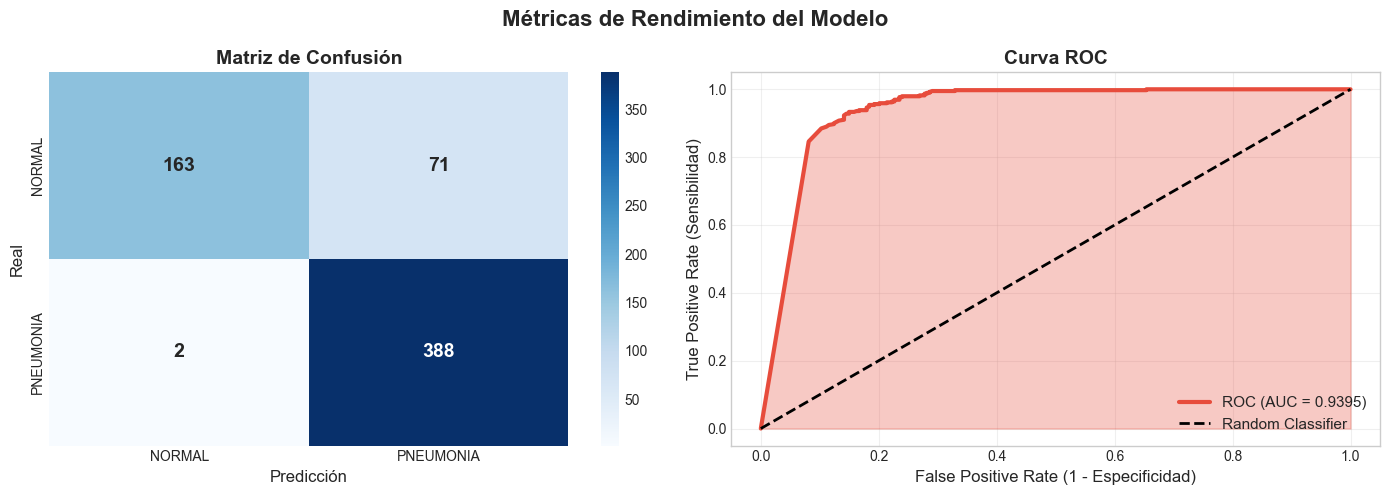


RESUMEN: MATRIZ DE CONFUSIÓN Y CURVA ROC
Verdaderos Negativos (VN): 163 - Pacientes sanos correctamente identificados
Falsos Positivos (FP):     71 - Pacientes sanos clasificados como neumonía
Falsos Negativos (FN):     2 - Casos de neumonía no detectados
Verdaderos Positivos (VP): 388 - Casos de neumonía correctamente detectados
----------------------------------------------------------------------
AUC-ROC: 0.9395
----------------------------------------------------------------------
INTERPRETACION:
- El modelo detecta el 99.5% de los casos de neumonía (Recall).
- Solo 2 caso(s) de neumonía no fueron detectados (Falsos Negativos).
- 71 pacientes sanos fueron clasificados como neumonía (Falsos Positivos).
- En contexto médico, es preferible minimizar FN (no perder casos de enfermedad)
  aunque esto genere más FP que pueden verificarse con estudios adicionales.
- AUC de 0.9395 indica excelente capacidad discriminativa del modelo.


In [45]:
# ============================================
# GRÁFICA 3: Matriz de Confusión y Curva ROC
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de Confusión
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=CLASSES, yticklabels=CLASSES,
            annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_xlabel('Predicción', fontsize=12)
axes[0].set_ylabel('Real', fontsize=12)
axes[0].set_title('Matriz de Confusión', fontsize=14, fontweight='bold')

# Curva ROC
fpr, tpr, _ = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='#e74c3c', linewidth=3, label=f'ROC (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
axes[1].fill_between(fpr, tpr, alpha=0.3, color='#e74c3c')
axes[1].set_xlabel('False Positive Rate (1 - Especificidad)', fontsize=12)
axes[1].set_ylabel('True Positive Rate (Sensibilidad)', fontsize=12)
axes[1].set_title('Curva ROC', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Métricas de Rendimiento del Modelo', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Resumen de la matriz de confusión y curva ROC
tn, fp, fn, tp = cm.ravel()
print("\n" + "="*70)
print("RESUMEN: MATRIZ DE CONFUSIÓN Y CURVA ROC")
print("="*70)
print(f"Verdaderos Negativos (VN): {tn} - Pacientes sanos correctamente identificados")
print(f"Falsos Positivos (FP):     {fp} - Pacientes sanos clasificados como neumonía")
print(f"Falsos Negativos (FN):     {fn} - Casos de neumonía no detectados")
print(f"Verdaderos Positivos (VP): {tp} - Casos de neumonía correctamente detectados")
print("-"*70)
print(f"AUC-ROC: {roc_auc:.4f}")
print("-"*70)
print("INTERPRETACION:")
print(f"- El modelo detecta el {100*tp/(tp+fn):.1f}% de los casos de neumonía (Recall).")
print(f"- Solo {fn} caso(s) de neumonía no fueron detectados (Falsos Negativos).")
print(f"- {fp} pacientes sanos fueron clasificados como neumonía (Falsos Positivos).")
print("- En contexto médico, es preferible minimizar FN (no perder casos de enfermedad)")
print("  aunque esto genere más FP que pueden verificarse con estudios adicionales.")
print(f"- AUC de {roc_auc:.4f} indica excelente capacidad discriminativa del modelo.")
print("="*70)